In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/amerzishminha/forest-fire-and-non-fire-dataset")

Skipping, found downloaded files in "./forest-fire-and-non-fire-dataset" (use force=True to force download)


In [ ]:
df = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/train/fire'):
    for filename in filenames:
        df = pd.concat([df, pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label'])], axis=0)

for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/train/non fire'):
    for filename in filenames:
        df = pd.concat([df, pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label'])], axis=0)

df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

df_test = pd.DataFrame(columns=['path','label'])
for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/test/fire'):
    for filename in filenames:
        df_test = pd.concat([df_test, pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label'])], axis=0)

for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/test/non fire'):
    for filename in filenames:
        df_test = pd.concat([df_test, pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label'])], axis=0)

df_test = df_test.sample(frac=1).reset_index(drop=True)

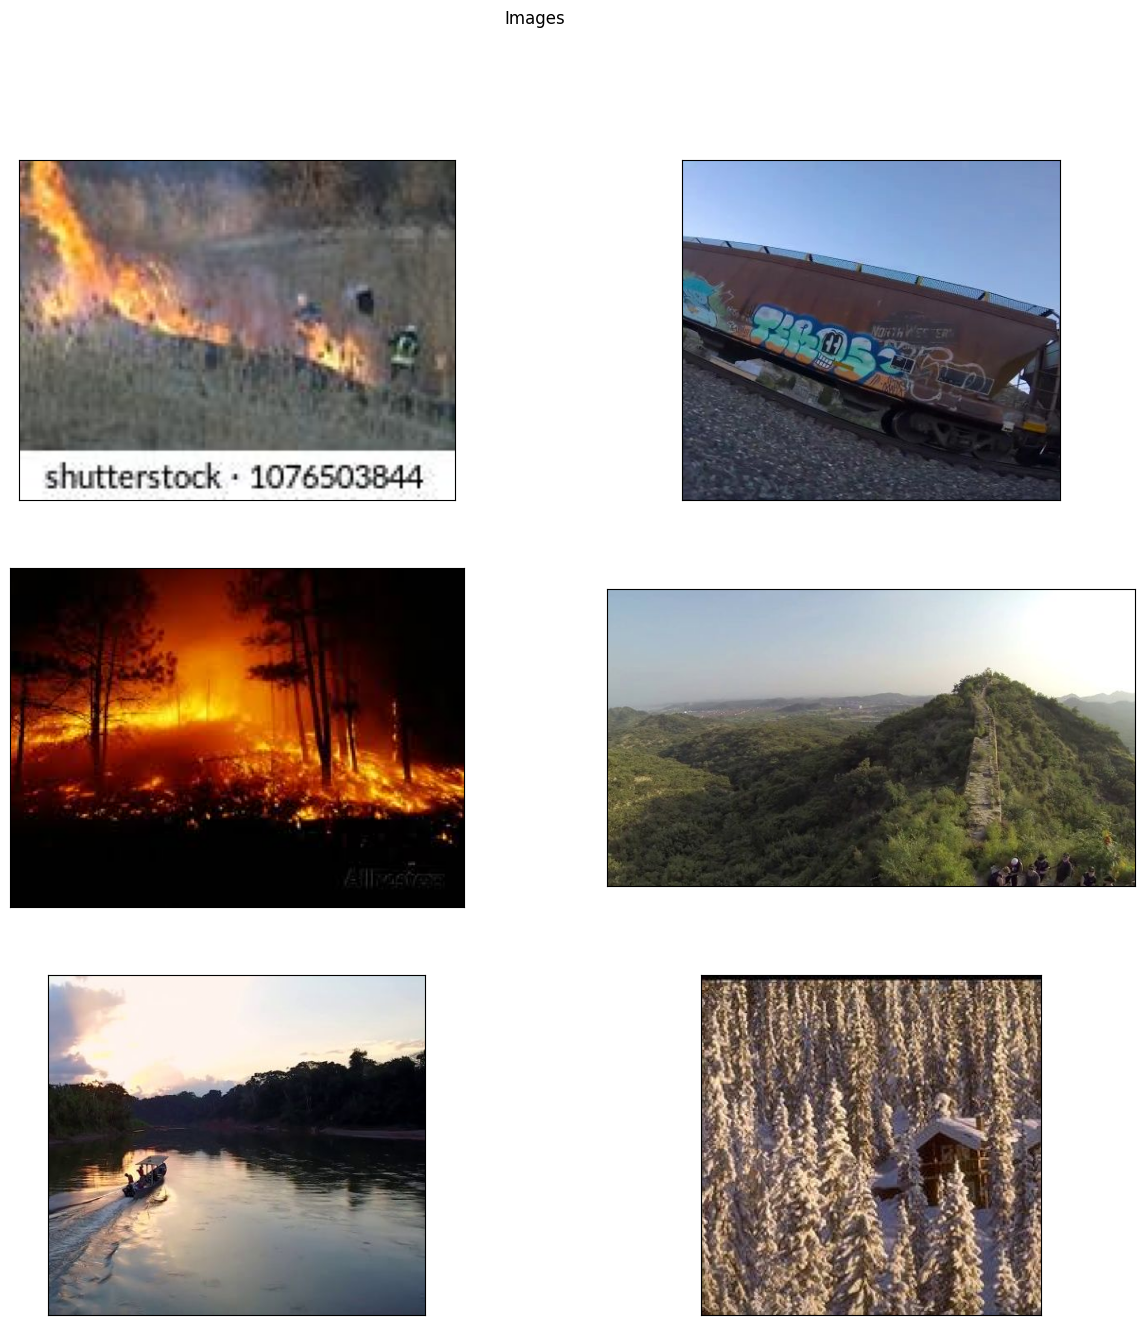

In [ ]:
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = df.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [ ]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row

In [ ]:
df = df.apply(shaper,axis=1)
df_test = df_test.apply(shaper,axis=1)
df.head(5)

path     label  height  width
0  /content/forest-fire-and-non-fire-dataset/FORE...      fire     759    762
1  /content/forest-fire-and-non-fire-dataset/FORE...      fire     541    960
2  /content/forest-fire-and-non-fire-dataset/FORE...      fire    1080   1920
3  /content/forest-fire-and-non-fire-dataset/FORE...  non_fire     250    250
4  /content/forest-fire-and-non-fire-dataset/FORE...  non_fire     720   1280

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
generator = ImageDataGenerator(
    rotation_range= 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [ ]:
train_gen = generator.flow_from_dataframe(df,x_col='path',y_col='label',images_size=(256,256),class_mode='binary')
val_gen = generator.flow_from_dataframe(df_test,x_col='path',y_col='label',images_size=(256,256),class_mode='binary')

Found 15609 validated image filenames belonging to 2 classes.
Found 6122 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key

print(class_indices)

{0: 'fire', 1: 'non_fire'}


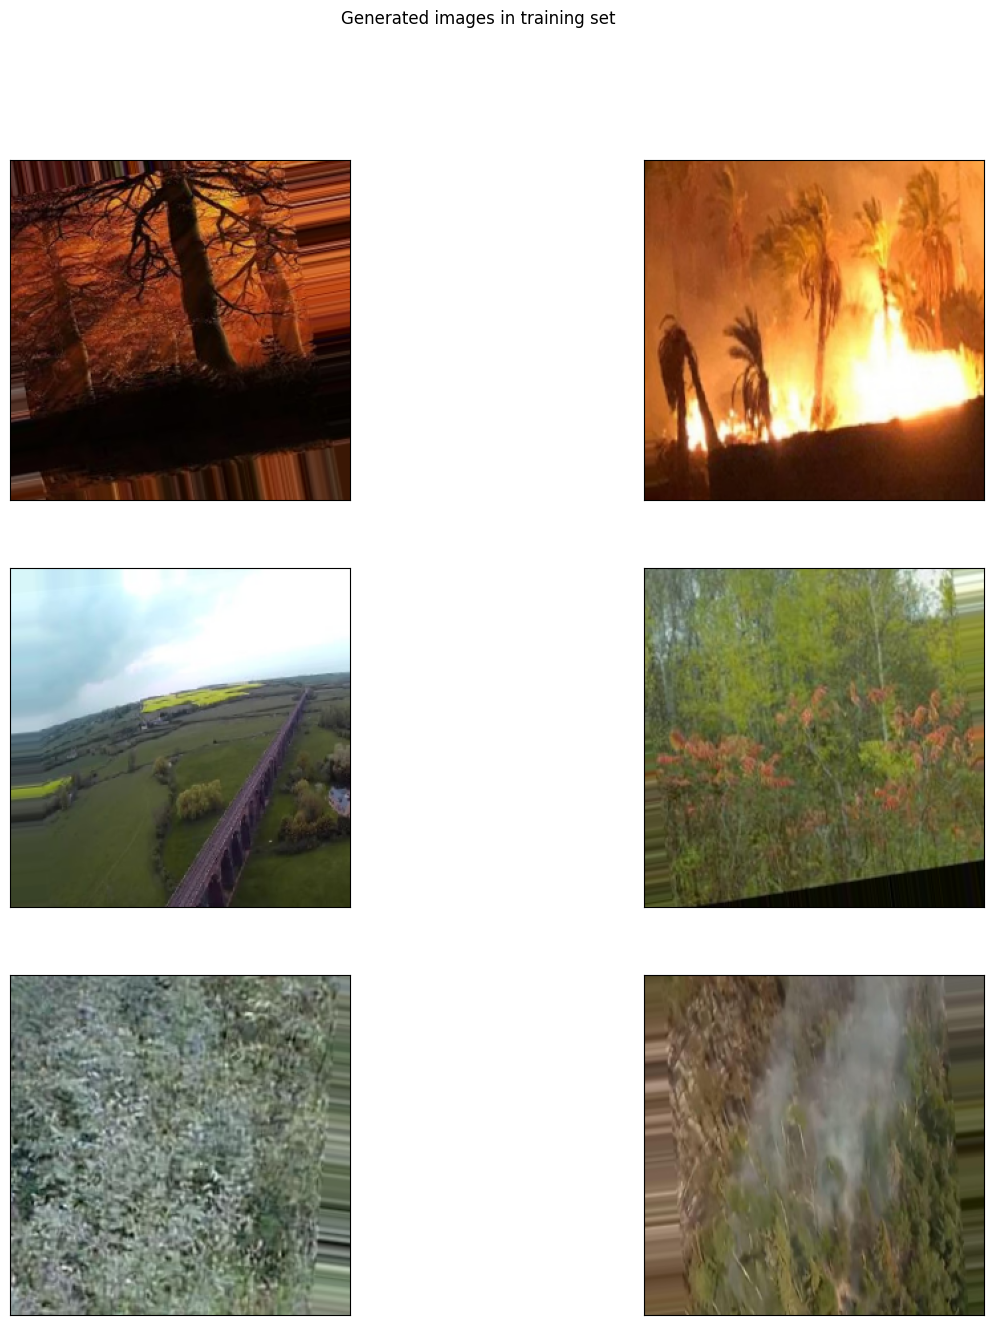

In [ ]:
pics = 6
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

## Transfer Learning

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
import tensorflow.keras

In [ ]:
feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
feat.trainable = False

82420632/82420632 [==============================] - 0s 0us/step


In [ ]:
model1 = Sequential()
model1.add(feat)
model1.add(Flatten())
model1.add(Dropout(0.2))
model1.add(Dense(64))
model1.add(Dense(1,activation='sigmoid'))

In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stoppping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)

In [ ]:
checkpoint_filepath = '/feat.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history=model1.fit(x=train_gen,batch_size=64,
          epochs=20,validation_data=val_gen,
          callbacks=[early_stoppping, model_checkpoint_callback])

Epoch 1/20
488/488 [==============================] - 496s 968ms/step - loss: 4.9694 - accuracy: 0.6736 - val_loss: 0.7691 - val_accuracy: 0.6859
Epoch 2/20
488/488 [==============================] - 474s 972ms/step - loss: 0.5374 - accuracy: 0.7463 - val_loss: 0.4480 - val_accuracy: 0.7886
Epoch 3/20
488/488 [==============================] - 482s 987ms/step - loss: 0.4887 - accuracy: 0.7567 - val_loss: 0.5030 - val_accuracy: 0.7475
Epoch 4/20
488/488 [==============================] - 455s 933ms/step - loss: 0.4902 - accuracy: 0.7595 - val_loss: 0.4543 - val_accuracy: 0.7878
Epoch 5/20
488/488 [==============================] - 459s 940ms/step - loss: 0.4959 - accuracy: 0.7608 - val_loss: 0.4668 - val_accuracy: 0.7792
Epoch 6/20
488/488 [==============================] - 452s 927ms/step - loss: 0.4937 - accuracy: 0.7629 - val_loss: 0.4685 - val_accuracy: 0.7849


In [ ]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'historyfeat.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
model1.evaluate(val_gen)

192/192 [==============================] - 122s 633ms/step - loss: 0.4421 - accuracy: 0.7948


[0.4421130418777466, 0.7948383092880249]

```
192/192 [==============================] - 122s 633ms/step - loss: 0.4421 - accuracy: 0.7948
[0.4421130418777466, 0.7948383092880249]
```

## Fine tuning

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow.keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True
for layer in feat.layers:
  i = i+1
  if i < 500:
    layer.trainable = False

feat.summary()

82420632/82420632 [==============================] - 5s 0us/step
Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 128, 128, 24)         96        ['stem_conv[0][0]']           
 n)               

In [ ]:
model2 = Sequential()
model2.add(feat)
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(64))
model2.add(Dense(1,activation='sigmoid'))
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 8, 8, 1280)        20331360  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dropout (Dropout)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 64)                5242944   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25574369 (97.56 MB)
Trainable params: 6168257 (23.53 MB)
Non-trainable params: 19406112 (74.03 MB)
_________

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stoppping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)
checkpoint_filepath = '/content/fine.weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history=model2.fit(x=train_gen,batch_size=64,
          epochs=20,validation_data=val_gen,
          callbacks=[early_stoppping,model_checkpoint_callback])

Epoch 1/20
488/488 [==============================] - 518s 1s/step - loss: 4.0766 - accuracy: 0.7045 - val_loss: 2.7577 - val_accuracy: 0.5462
Epoch 2/20
488/488 [==============================] - 475s 975ms/step - loss: 0.6003 - accuracy: 0.7648 - val_loss: 0.4080 - val_accuracy: 0.8128
Epoch 3/20
488/488 [==============================] - 477s 978ms/step - loss: 0.4239 - accuracy: 0.8040 - val_loss: 0.3726 - val_accuracy: 0.8357
Epoch 4/20
488/488 [==============================] - 479s 983ms/step - loss: 0.4064 - accuracy: 0.8111 - val_loss: 0.3845 - val_accuracy: 0.8233
Epoch 5/20
488/488 [==============================] - 469s 962ms/step - loss: 0.3959 - accuracy: 0.8202 - val_loss: 0.4187 - val_accuracy: 0.7996
Epoch 6/20
488/488 [==============================] - 477s 977ms/step - loss: 0.3907 - accuracy: 0.8217 - val_loss: 0.3599 - val_accuracy: 0.8383
Epoch 7/20
488/488 [==============================] - 486s 995ms/step - loss: 0.3839 - accuracy: 0.8261 - val_loss: 0.5116 - va

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'historyfine.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
model2.evaluate(val_gen)

192/192 [==============================] - 128s 667ms/step - loss: 0.3412 - accuracy: 0.8502


[0.34122052788734436, 0.8502123355865479]

```
192/192 [==============================] - 128s 667ms/step - loss: 0.3412 - accuracy: 0.8502
[0.34122052788734436, 0.8502123355865479]
```

## BoWFire

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iKTzY0D4SUS2HnMxEYIf")
project = rf.workspace("gachon-najs3").project("bowfire-0fqng")
version = project.version(1)
dataset = version.download("tensorflow")


loading Roboflow workspace...
loading Roboflow project...


In [ ]:
df_bow = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('/content/BoWFire-1/test'):
    for filename in filenames:
      if filename != '_annotations.csv':
        lab = "fire" if filename[0]=='f' else "non_fire"
        df_bow = pd.concat([df_bow, pd.DataFrame([[os.path.join(dirname, filename),lab]],columns=['path','label'])], axis=0)

df_bow = df_bow.sample(frac=1).reset_index(drop=True)
df_bow.head(10)

path     label
0  /content/BoWFire-1/test/fire047_png.rf.ed0f314...      fire
1  /content/BoWFire-1/test/not_fire009_png.rf.9fe...  non_fire
2  /content/BoWFire-1/test/fire114_png.rf.0b73ae0...      fire
3  /content/BoWFire-1/test/fire029_png.rf.7ce0a88...      fire
4  /content/BoWFire-1/test/not_fire073_png.rf.e74...  non_fire
5  /content/BoWFire-1/test/fire025_png.rf.2abf33e...      fire
6  /content/BoWFire-1/test/not_fire086_png.rf.c93...  non_fire
7  /content/BoWFire-1/test/fire062_png.rf.7112428...      fire
8  /content/BoWFire-1/test/fire026_png.rf.42ff645...      fire
9  /content/BoWFire-1/test/not_fire002_png.rf.20f...  non_fire

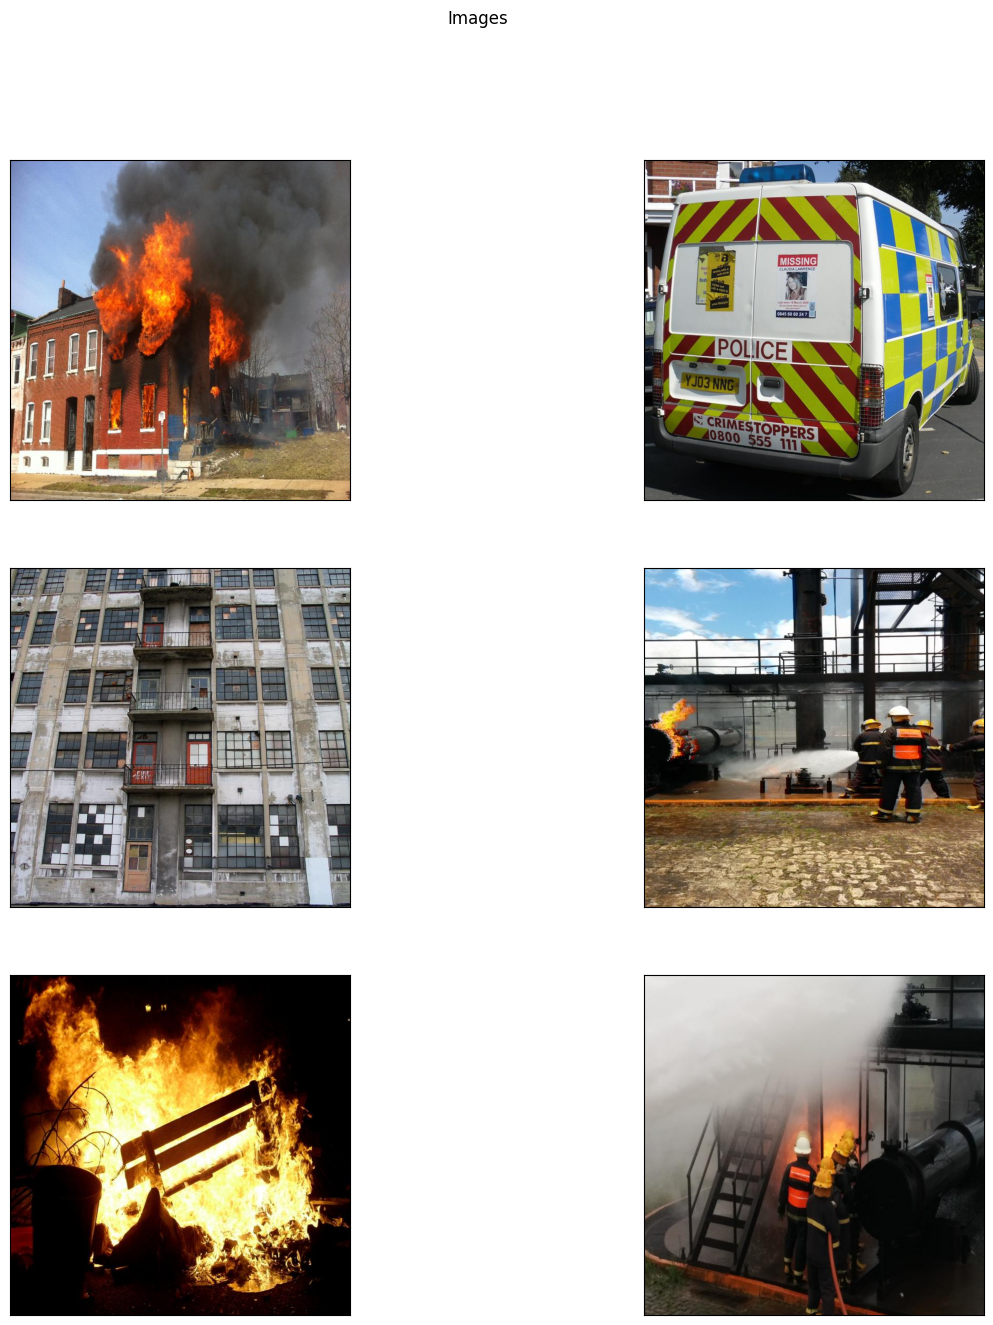

In [ ]:
pics = 6 #set the number of pics
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = df_bow.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

In [ ]:
train_bow = generator.flow_from_dataframe(df_bow,x_col='path',y_col='label',images_size=(256,256),class_mode='binary')

Found 226 validated image filenames belonging to 2 classes.


In [ ]:
model2.evaluate(train_bow)

8/8 [==============================] - 6s 683ms/step - loss: 1.0258 - accuracy: 0.6372


[1.025817632675171, 0.6371681690216064]

```
8/8 [==============================] - 6s 683ms/step - loss: 1.0258 - accuracy: 0.6372
[1.025817632675171, 0.6371681690216064]
```

## Training biasa

In [ ]:
retrain_model = tf.keras.models.clone_model(model2)
retrain_model.set_weights(model2.get_weights())

In [ ]:
retrain_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stoppping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)

retrain_model.fit(x=train_bow,batch_size=64,
          epochs=20,validation_data=val_gen,
          callbacks=[early_stoppping])

Epoch 1/20
8/8 [==============================] - 181s 22s/step - loss: 0.8212 - accuracy: 0.6150 - val_loss: 0.5929 - val_accuracy: 0.6627
Epoch 2/20
8/8 [==============================] - 130s 18s/step - loss: 0.6202 - accuracy: 0.6549 - val_loss: 0.6040 - val_accuracy: 0.6571
Epoch 3/20
8/8 [==============================] - 130s 18s/step - loss: 0.6113 - accuracy: 0.7124 - val_loss: 0.6895 - val_accuracy: 0.6068
Epoch 4/20
8/8 [==============================] - 131s 19s/step - loss: 0.5417 - accuracy: 0.7434 - val_loss: 0.5549 - val_accuracy: 0.6994
Epoch 5/20
8/8 [==============================] - 129s 18s/step - loss: 0.5965 - accuracy: 0.7168 - val_loss: 0.5292 - val_accuracy: 0.7302
Epoch 6/20
8/8 [==============================] - 131s 19s/step - loss: 0.4822 - accuracy: 0.7876 - val_loss: 0.5392 - val_accuracy: 0.7112
Epoch 7/20
8/8 [==============================] - 133s 19s/step - loss: 0.4283 - accuracy: 0.8097 - val_loss: 0.5964 - val_accuracy: 0.6789
Epoch 8/20
8/8 [====

In [ ]:
retrain_model.evaluate(val_gen)

192/192 [==============================] - 129s 669ms/step - loss: 0.5261 - accuracy: 0.7293


[0.5261464715003967, 0.7293367981910706]

```
192/192 [==============================] - 129s 669ms/step - loss: 0.5261 - accuracy: 0.7293
[0.5261464715003967, 0.7293367981910706]
```

In [ ]:
retrain_model.evaluate(train_bow)

8/8 [==============================] - 5s 656ms/step - loss: 0.4435 - accuracy: 0.7876


[0.4434582591056824, 0.7876105904579163]

```
8/8 [==============================] - 5s 656ms/step - loss: 0.4435 - accuracy: 0.7876
[0.4434582591056824, 0.7876105904579163]
```

## Dataset campur

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow.keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
mix_bow_train = df_bow.sample(frac=0.8)
mix_bow_test = df_bow.drop(mix_bow_train.index)
df_mix = pd.concat([df,mix_bow_train])
train_mix = generator.flow_from_dataframe(df_mix,x_col='path',y_col='label',images_size=(256,256),class_mode='binary')
df_mix_test = pd.concat([df_test,mix_bow_test])
test_mix = generator.flow_from_dataframe(df_mix_test,x_col='path',y_col='label',images_size=(256,256),class_mode='binary')

Found 15790 validated image filenames belonging to 2 classes.
Found 6167 validated image filenames belonging to 2 classes.


Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.


In [ ]:
feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True
for layer in feat.layers:
  i = i+1
  if i < 500:
    layer.trainable = False


model_mix = Sequential()
model_mix.add(feat)
model_mix.add(Flatten())
model_mix.add(Dropout(0.2))
model_mix.add(Dense(64))
model_mix.add(Dense(1,activation='sigmoid'))
model_mix.summary()

82420632/82420632 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 8, 8, 1280)        20331360  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dropout (Dropout)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 64)                5242944   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25574369 (97.56 MB)
Trainable params: 61682

In [ ]:
model_mix.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stoppping = EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)
model_mix.fit(x=train_mix,batch_size=64,
          epochs=20,validation_data=test_mix,
          callbacks=[early_stoppping])

Epoch 1/20
494/494 [==============================] - 517s 974ms/step - loss: 3.6167 - accuracy: 0.7018 - val_loss: 0.4298 - val_accuracy: 0.8211
Epoch 2/20
494/494 [==============================] - 472s 954ms/step - loss: 0.4942 - accuracy: 0.7800 - val_loss: 0.3868 - val_accuracy: 0.8210
Epoch 3/20
494/494 [==============================] - 471s 953ms/step - loss: 0.4248 - accuracy: 0.8030 - val_loss: 0.4150 - val_accuracy: 0.8061
Epoch 4/20
494/494 [==============================] - 477s 965ms/step - loss: 0.4064 - accuracy: 0.8134 - val_loss: 0.4137 - val_accuracy: 0.8119


In [ ]:
model_mix.evaluate(val_gen)

192/192 [==============================] - 127s 662ms/step - loss: 0.3852 - accuracy: 0.8247


[0.38515597581863403, 0.8247304558753967]

In [ ]:
model_mix.evaluate(train_bow)

8/8 [==============================] - 5s 591ms/step - loss: 0.8357 - accuracy: 0.6239


[0.835720956325531, 0.6238937973976135]

In [ ]:
small_test = generator.flow_from_dataframe(mix_bow_test,x_col='path',y_col='label',images_size=(256,256),class_mode='binary')
model_mix.evaluate(small_test)

Found 45 validated image filenames belonging to 2 classes.
2/2 [==============================] - 2s 2s/step - loss: 0.7753 - accuracy: 0.6667


[0.7752946019172668, 0.6666666865348816]

## Joint Training

### normal model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
model_temp = Sequential()
model_temp.add(feat)
model_temp.add(Flatten())
model_temp.add(Dropout(0.2))
model_temp.add(Dense(64))
model_temp.add(Dense(1,activation='sigmoid'))

model_temp.load_weights('/content/drive/MyDrive/fine.weights.h5')
model_joint1 = tf.keras.models.Model(model_temp.input, model_temp.layers[-4].output)
model_joint1.trainable = False
model_joint1.summary()

82420632/82420632 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s_input (In  [(None, 256, 256, 3)]     0         
 putLayer)                                                       
                                                                 
 efficientnetv2-s (Function  (None, 8, 8, 1280)        20331360  
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
Total params: 20331360 (77.56 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


### bow model

In [ ]:
model_temp2 = Sequential()
model_temp2.add(feat)
model_temp2.add(Flatten())
model_temp2.add(Dropout(0.2))
model_temp2.add(Dense(64))
model_temp2.add(Dense(1,activation='sigmoid'))
model_temp2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Function  (None, 8, 8, 1280)        20331360  
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 81920)             0         
                                                                 
 dropout_1 (Dropout)         (None, 81920)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                5242944   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25574369 (97.56 MB)
Trainable params: 5243009 (20.00 MB)
Non-trainable params: 20331360 (77.56 MB)
_______

In [ ]:
model_temp2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stoppping = EarlyStopping(monitor='loss',patience=4,restore_best_weights=True)
model_temp2.fit(x=train_bow,batch_size=64,
          epochs=20,
          callbacks=[early_stoppping])

Epoch 1/20
1/1 [==============================] - 29s 29s/step - loss: 0.8026 - accuracy: 0.4381
Epoch 2/20
1/1 [==============================] - 5s 5s/step - loss: 34.5533 - accuracy: 0.5265
Epoch 3/20
1/1 [==============================] - 5s 5s/step - loss: 11.3004 - accuracy: 0.6504
Epoch 4/20
1/1 [==============================] - 5s 5s/step - loss: 12.9712 - accuracy: 0.5619
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 13.9716 - accuracy: 0.5619


In [ ]:
model_joint2 = tf.keras.models.Model(model_temp2.input, model_temp2.layers[-4].output)
model_joint2.trainable = False
for layer in model_joint2.layers:
  layer._name = layer.name + str("_2")
model_joint2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s_input_2 (  [(None, 256, 256, 3)]     0         
 InputLayer)                                                     
                                                                 
 efficientnetv2-s_2 (Functi  (None, 8, 8, 1280)        20331360  
 onal)                                                           
                                                                 
 flatten_1_2 (Flatten)       (None, 81920)             0         
                                                                 
Total params: 20331360 (77.56 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


### joint model

In [ ]:
out = tf.keras.layers.Concatenate()([model_joint1.output, model_joint2.output])
out = tf.keras.layers.Dense(64)(out)
out = tf.keras.layers.Dense(1, activation='sigmoid')(out)
model_joint = tf.keras.models.Model(inputs=[model_joint1.input, model_joint2.input], outputs=out)
model_joint.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 efficientnetv2-s_input (In  [(None, 256, 256, 3)]        0         []                            
 putLayer)                                                                                        
                                                                                                  
 efficientnetv2-s_input_2 (  [(None, 256, 256, 3)]        0         []                            
 InputLayer)                                                                                      
                                                                                                  
 efficientnetv2-s_2 (Functi  (None, 8, 8, 1280)           2033136   ['efficientnetv2-s_input[0][0]
 onal)                                                    0         ',                      

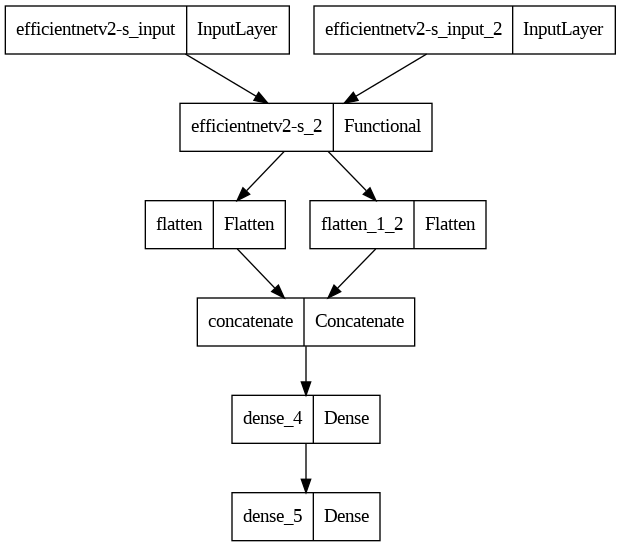

In [ ]:
tf.keras.utils.plot_model(model_joint, to_file='joint.png')

In [ ]:
model_joint.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stoppping = EarlyStopping(monitor='loss',patience=4,restore_best_weights=True)

In [ ]:
df = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/train/fire'):
    for filename in filenames:
        df = pd.concat([df, pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label'])], axis=0)

for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/train/non fire'):
    for filename in filenames:
        df = pd.concat([df, pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label'])], axis=0)

df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
train_bow.reset()
# index = train_bow.next()
# print(np.array(index[0]).shape)
np_bow_x=np.concatenate([train_bow.next()[0] for i in range(train_bow.__len__())])
np_bow_y=np.concatenate([train_bow.next()[1] for i in range(train_bow.__len__())])
print(np_bow_x.shape)
print(np_bow_y.shape)

(226, 256, 256, 3)
(226,)


In [ ]:
train_gen = generator.flow_from_dataframe(df[:300],x_col='path',y_col='label',images_size=(256,256),class_mode='binary')
val_gen = generator.flow_from_dataframe(df_test[:300],x_col='path',y_col='label',images_size=(256,256),class_mode='binary')

Found 300 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [ ]:
train_gen.reset()
# index = train_bow.next()
# print(np.array(index[0]).shape)
np_gen_x=np.concatenate([train_gen.next()[0] for i in range(train_gen.__len__())])
np_gen_y=np.concatenate([train_gen.next()[1] for i in range(train_gen.__len__())])
print(np_gen_x.shape)
print(np_gen_y.shape)

(300, 256, 256, 3)
(300,)


Your session crashed after using all available RAM

21 000 x 256 x 256 x 3 x (4 byte) =
16.515072 gigabytes

In [ ]:
np_x = np.concatenate([np_bow_x, np_gen_x])
np_y = np.concatenate([np_bow_y, np_gen_y])

In [ ]:
model_joint.fit(x=[np_x,np_x], y=np_y,
          batch_size=64,
          epochs=20,
          #validation_data=test_mix_joint,
          callbacks=[early_stoppping])

Epoch 1/20
9/9 [==============================] - 7s 759ms/step - loss: 9.4523 - accuracy: 0.5361
Epoch 2/20
9/9 [==============================] - 7s 741ms/step - loss: 8.1678 - accuracy: 0.5551
Epoch 3/20
9/9 [==============================] - 7s 752ms/step - loss: 5.1916 - accuracy: 0.6160
Epoch 4/20
9/9 [==============================] - 6s 700ms/step - loss: 3.2176 - accuracy: 0.6825
Epoch 5/20
9/9 [==============================] - 6s 636ms/step - loss: 2.6237 - accuracy: 0.7605
Epoch 6/20
9/9 [==============================] - 6s 687ms/step - loss: 2.2540 - accuracy: 0.7357
Epoch 7/20
9/9 [==============================] - 6s 663ms/step - loss: 2.0241 - accuracy: 0.7529
Epoch 8/20
9/9 [==============================] - 5s 600ms/step - loss: 2.5194 - accuracy: 0.7490
Epoch 9/20
9/9 [==============================] - 5s 588ms/step - loss: 1.3659 - accuracy: 0.8080
Epoch 10/20
9/9 [==============================] - 5s 608ms/step - loss: 0.7780 - accuracy: 0.8688
Epoch 11/20
9/9 [==

In [ ]:
model_joint.evaluate(x=[np_bow_x,np_bow_x],y=np_bow_y)

8/8 [==============================] - 13s 385ms/step - loss: 0.2041 - accuracy: 0.9558


[0.20413696765899658, 0.9557521939277649]

In [ ]:
val_gen.reset()
# index = train_bow.next()
# print(np.array(index[0]).shape)
np_val_x=np.concatenate([val_gen.next()[0] for i in range(val_gen.__len__())])
np_val_y=np.concatenate([val_gen.next()[1] for i in range(val_gen.__len__())])
print(np_val_x.shape)
print(np_val_y.shape)

(300, 256, 256, 3)
(300,)


In [ ]:
model_joint.evaluate(x=[np_val_x,np_val_x],y=np_val_y)

10/10 [==============================] - 4s 426ms/step - loss: 5.5799 - accuracy: 0.5100


[5.579863548278809, 0.5099999904632568]

## Learning Without Forgetting

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
generator = ImageDataGenerator(
    rotation_range= 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
)

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iKTzY0D4SUS2HnMxEYIf")
project = rf.workspace("gachon-najs3").project("bowfire-0fqng")
version = project.version(1)
dataset = version.download("tensorflow")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.7 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycl

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BoWFire-1 in tensorflow:: 100%|██████████| 230/230 [00:00<00:00, 2886.17it/s]


In [ ]:
df_bow = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('/content/BoWFire-1/test'):
    for filename in filenames:
      if filename != '_annotations.csv':
        lab = "fire" if filename[0]=='f' else "non_fire"
        df_bow = pd.concat([df_bow, pd.DataFrame([[os.path.join(dirname, filename),lab]],columns=['path','label'])], axis=0)

df_bow = df_bow.sample(frac=1).reset_index(drop=True)
df_bow.head(10)

path     label
0  /content/BoWFire-1/test/not_fire088_png.rf.728...  non_fire
1  /content/BoWFire-1/test/not_fire008_png.rf.ae0...  non_fire
2  /content/BoWFire-1/test/fire078_png.rf.1449980...      fire
3  /content/BoWFire-1/test/not_fire095_png.rf.d7b...  non_fire
4  /content/BoWFire-1/test/fire074_png.rf.c51c907...      fire
5  /content/BoWFire-1/test/not_fire007_png.rf.f03...  non_fire
6  /content/BoWFire-1/test/not_fire057_png.rf.3d7...  non_fire
7  /content/BoWFire-1/test/fire052_png.rf.49db64e...      fire
8  /content/BoWFire-1/test/fire081_png.rf.8fe7cce...      fire
9  /content/BoWFire-1/test/fire011_png.rf.d4a2cc5...      fire

In [ ]:
train_bow = generator.flow_from_dataframe(df_bow,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',batch_size=226)

Found 226 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
import tensorflow.keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True
# for layer in feat.layers:
#   i = i+1
#   if i < 500:
#     layer.trainable = False
old = Sequential()
old.add(feat)
old.add(Flatten())
old.add(Dropout(0.2))
old.add(Dense(64))
old.add(Dense(1,activation='sigmoid'))

old.load_weights('drive/MyDrive/fine.weights.h5')
old.trainable = False
# old.summary()

In [ ]:
xbow,ybow = train_bow.next()

In [ ]:
# def k_dist_loss(logits, labels):

#     labels = tf.cast(labels, dtype='float32')
#     logits = tf.cast(logits, dtype='float32')
#     # print(labels.shape)
#     # print(logits.shape)

#     outputs = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction="none")(labels, logits)
#     # print(labels)
#     # print(logits)
#     # print(outputs)

#     return outputs

def lwf_loss_f(labels, logits, heads_labels, alpha = 0.45):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)
    # for i in range(len(heads_labels)):
    #     loss2 += k_dist_loss(labels=heads_labels[i], logits=logits[i])

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    # print("loss1:",loss1)
    # print("loss2:",loss2)
    # print("loss:",loss)
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      # print(logits)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))
    # print(labels)
    # print(np.where(logits>=0.5,1.,0.))
    # print(train_acc_metric.result())

    return loss

In [ ]:
feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True
# for layer in feat.layers:
#   i = i+1
#   if i < 500:
#     layer.trainable = False

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
new.load_weights('drive/MyDrive/fine.weights.h5')
# new.summary()

In [ ]:
tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        # print(epoch+1,batch+1)
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]
        # print(labels.shape)

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        # print(labels)
        # print(heads_labels)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  # elif loss - best_loss < 0.05: # threshold
  #   epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

Epoch  1 / 200
1/1 [==============================] - 1s 504ms/step
0.9241937 0.67900485
1/1 [==============================] - 0s 340ms/step
1.9824144 0.85750705
1/1 [==============================] - 0s 341ms/step
0.5015417 1.3374923
1/1 [==============================] - 0s 342ms/step
0.84108406 0.3831283
1/1 [==============================] - 0s 338ms/step
0.64376515 0.864634
1/1 [==============================] - 0s 452ms/step
0.71268034 0.56936747
1/1 [==============================] - 0s 344ms/step
0.757695 0.49063525
1/1 [==============================] - 0s 334ms/step
0.93162614 0.6228089
1/1 [==============================] - 0s 331ms/step
0.484017 0.6051972
1/1 [==============================] - 0s 337ms/step
0.88099647 0.38823298
1/1 [==============================] - 0s 354ms/step
0.596481 0.6518242
1/1 [==============================] - 0s 477ms/step
0.38358498 1.0905392
1/1 [==============================] - 0s 337ms/step
0.1918649 0.24820076
1/1 [=======================

In [ ]:
old.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
old.evaluate(train_bow)

1/1 [==============================] - 5s 5s/step - loss: 0.7986 - accuracy: 0.6106


[0.7985732555389404, 0.6106194853782654]

```
1/1 [==============================] - 11s 11s/step - loss: 0.8199 - accuracy: 0.5929
[0.8199096918106079, 0.5929203629493713]
```

In [ ]:
new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)

1/1 [==============================] - 5s 5s/step - loss: 0.5075 - accuracy: 0.7345


[0.5074753761291504, 0.7345132827758789]

```
1/1 [==============================] - 6s 6s/step - loss: 0.2763 - accuracy: 0.8186
[0.2762857973575592, 0.8185840845108032]
```

In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/amerzishminha/forest-fire-and-non-fire-dataset")

Dataset URL: https://www.kaggle.com/datasets/amerzishminha/forest-fire-and-non-fire-dataset


100%|██████████| 3.48G/3.48G [02:05<00:00, 29.7MB/s]


In [ ]:
# df = pd.DataFrame(columns=['path','label'])

# for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/train/fire'):
#     for filename in filenames:
#         df = pd.concat([df, pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label'])], axis=0)

# for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/train/non fire'):
#     for filename in filenames:
#         df = pd.concat([df, pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label'])], axis=0)

# df = df.sample(frac=1).reset_index(drop=True)
# df.head(10)

df_test = pd.DataFrame(columns=['path','label'])
for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/test/fire'):
    for filename in filenames:
        df_test = pd.concat([df_test, pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label'])], axis=0)

for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/test/non fire'):
    for filename in filenames:
        df_test = pd.concat([df_test, pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label'])], axis=0)

df_test = df_test.sample(frac=1).reset_index(drop=True)

In [ ]:
test_gen = generator.flow_from_dataframe(df_test,x_col='path',y_col='label',images_size=(256,256),class_mode='binary')

Found 6122 validated image filenames belonging to 2 classes.


Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.


In [ ]:
old.evaluate(test_gen)

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.


192/192 [==============================] - 166s 863ms/step - loss: 0.3443 - accuracy: 0.8546


[0.34432440996170044, 0.8546226620674133]

```
192/192 [==============================] - 177s 911ms/step - loss: 0.3450 - accuracy: 0.8528
[0.3450217545032501, 0.8528258800506592]
```

In [ ]:
new.evaluate(test_gen)

 44/192 [=====>........................] - ETA: 2:04 - loss: 0.6551 - accuracy: 0.6030

```
192/192 [==============================] - 196s 1s/step - loss: 0.5048 - accuracy: 0.7328
[0.5048077702522278, 0.7327670454978943]
```

In [ ]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
new.predict(train_bow)

## Tests

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
import tensorflow.keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import time

!pip install roboflow
from roboflow import Roboflow

!pip install opendatasets
import opendatasets as od

generator = ImageDataGenerator(
    rotation_range= 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
)
rf = Roboflow(api_key="iKTzY0D4SUS2HnMxEYIf")
project = rf.workspace("gachon-najs3").project("bowfire-0fqng")
version = project.version(1)
dataset = version.download("tensorflow")
df_bow = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk('/content/BoWFire-1/test'):
    for filename in filenames:
      if filename != '_annotations.csv':
        lab = "fire" if filename[0]=='f' else "non_fire"
        df_bow = pd.concat([df_bow, pd.DataFrame([[os.path.join(dirname, filename),lab]],columns=['path','label'])], axis=0)

df_bow = df_bow.sample(frac=1).reset_index(drop=True)
train_bow = generator.flow_from_dataframe(df_bow,x_col='path',y_col='label',images_size=(256,256),class_mode='binary',batch_size=226)
from google.colab import drive
drive.mount('/content/drive')
xbow,ybow = train_bow.next()

od.download(
    "https://www.kaggle.com/datasets/amerzishminha/forest-fire-and-non-fire-dataset")

df_test = pd.DataFrame(columns=['path','label'])
for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/test/fire'):
    for filename in filenames:
        df_test = pd.concat([df_test, pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label'])], axis=0)

for dirname, _, filenames in os.walk('/content/forest-fire-and-non-fire-dataset/FOREST_FIRE_DATASET/test/non fire'):
    for filename in filenames:
        df_test = pd.concat([df_test, pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label'])], axis=0)

df_test = df_test.sample(frac=1).reset_index(drop=True)
test_gen = generator.flow_from_dataframe(df_test,x_col='path',y_col='label',images_size=(256,256),class_mode='binary')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BoWFire-1 in tensorflow:: 100%|██████████| 230/230 [00:00<00:00, 5338.39it/s]


Found 226 validated image filenames belonging to 2 classes.
Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/amerzishminha/forest-fire-and-non-fire-dataset


100%|██████████| 3.48G/3.48G [00:48<00:00, 76.7MB/s]



Found 6122 validated image filenames belonging to 2 classes.


Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.


In [ ]:
feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True
old = Sequential()
old.add(feat)
old.add(Flatten())
old.add(Dropout(0.2))
old.add(Dense(64))
old.add(Dense(1,activation='sigmoid'))

old.load_weights('drive/MyDrive/fine.weights.h5')
old.trainable = False

82420632/82420632 [==============================] - 3s 0us/step


In [ ]:
old.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
old.evaluate(train_bow)
old.evaluate(test_gen)

192/192 [==============================] - 140s 716ms/step - loss: 0.3412 - accuracy: 0.8556


[0.3412315547466278, 0.8556027412414551]

In [ ]:
def lwf_loss_f(labels, logits, heads_labels, alpha = 0.5):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))

    return loss

feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
new.load_weights('drive/MyDrive/fine.weights.h5')

tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)
new.evaluate(test_gen)

Epoch  1 / 200


Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.


1/1 [==============================] - 1s 1s/step
0.8477624 0.6490114
1/1 [==============================] - 0s 400ms/step
0.47267985 0.82242984
1/1 [==============================] - 1s 561ms/step
0.6689568 0.7795391
1/1 [==============================] - 1s 502ms/step
0.7252119 0.889424
1/1 [==============================] - 0s 346ms/step
0.68004173 0.541419
1/1 [==============================] - 0s 349ms/step
0.6902926 0.72586185
1/1 [==============================] - 0s 375ms/step
0.545914 0.63652605
1/1 [==============================] - 1s 501ms/step
0.6158189 0.4347115
1/1 [==============================] - 0s 332ms/step
0.25312212 0.5697025
1/1 [==============================] - 0s 339ms/step
0.3711036 0.5439378
1/1 [==============================] - 0s 340ms/step
0.8368837 1.2071241
1/1 [==============================] - 0s 334ms/step
0.90919226 0.54100484
1/1 [==============================] - 0s 451ms/step
0.075003274 1.0364074
1/1 [==============================] - 0s 342ms

[0.46136173605918884, 0.8173799514770508]

In [ ]:
def lwf_loss_f(labels, logits, heads_labels, alpha = 0.5):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))

    return loss

feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
# new.load_weights('drive/MyDrive/fine.weights.h5')

tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)
new.evaluate(test_gen)

Epoch  1 / 200
1/1 [==============================] - 0s 379ms/step
0.8937011 0.7513434
1/1 [==============================] - 0s 338ms/step
6.1763625 5.1110053
1/1 [==============================] - 0s 329ms/step
9.514115 10.465451
1/1 [==============================] - 0s 461ms/step
7.1387877 12.980236
1/1 [==============================] - 0s 457ms/step
4.5900455 8.594487
1/1 [==============================] - 0s 337ms/step
11.374515 3.934169
1/1 [==============================] - 0s 335ms/step
7.837612 14.075654
1/1 [==============================] - 0s 339ms/step
16.198467 13.447093
1/1 [==============================] - 0s 343ms/step
3.8689873 8.652642
1/1 [==============================] - 0s 451ms/step
32.545532 21.669115
1/1 [==============================] - 0s 344ms/step
34.415253 35.94011
1/1 [==============================] - 0s 352ms/step
17.307653 8.223577
1/1 [==============================] - 0s 336ms/step
7.965557 3.012883
1/1 [==============================] - 0s 348

[1.1734484434127808, 0.582652747631073]

In [ ]:
def lwf_loss_f(labels, logits, heads_labels, alpha = 0.02):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))

    return loss

feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
new.load_weights('drive/MyDrive/fine.weights.h5')

tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)
new.evaluate(test_gen)

Epoch  1 / 200
1/1 [==============================] - 0s 371ms/step
0.649022 0.75599194
1/1 [==============================] - 0s 342ms/step
0.25974187 0.44721404
1/1 [==============================] - 0s 359ms/step
0.5660225 0.5215803
1/1 [==============================] - 0s 331ms/step
0.9004884 0.6745732
1/1 [==============================] - 0s 463ms/step
0.8035252 0.532754
1/1 [==============================] - 0s 344ms/step
0.5850611 0.48774815
1/1 [==============================] - 0s 347ms/step
0.6411922 0.7769265
1/1 [==============================] - 0s 348ms/step
0.5662566 0.5545548
1/1 [==============================] - 0s 343ms/step
0.5694583 0.36059093
1/1 [==============================] - 0s 475ms/step
0.94488335 0.57342464
1/1 [==============================] - 0s 464ms/step
1.3618455 1.2189661
1/1 [==============================] - 0s 334ms/step
1.3280997 0.58796144
1/1 [==============================] - 0s 342ms/step
0.66222036 0.34835505
1/1 [=======================

[0.6560782194137573, 0.6898072361946106]

In [ ]:
def lwf_loss_f(labels, logits, heads_labels, alpha = 0.98):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))

    return loss

feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
new.load_weights('drive/MyDrive/fine.weights.h5')

tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)
new.evaluate(test_gen)

Epoch  1 / 200
1/1 [==============================] - 0s 368ms/step
0.86495906 0.9306936
1/1 [==============================] - 0s 367ms/step
0.20816822 0.61016905
1/1 [==============================] - 0s 462ms/step
0.507101 0.9669581
1/1 [==============================] - 0s 343ms/step
0.5140212 1.0108997
1/1 [==============================] - 0s 342ms/step
0.7656681 2.4458447
1/1 [==============================] - 0s 334ms/step
0.22881745 1.0681769
1/1 [==============================] - 0s 343ms/step
0.17551096 1.8822317
1/1 [==============================] - 0s 431ms/step
0.7938052 0.792685
1/1 [==============================] - 0s 338ms/step
0.57437867 0.9834208
1/1 [==============================] - 0s 341ms/step
0.55859876 0.59625036
1/1 [==============================] - 0s 336ms/step
0.7171719 1.2504379
1/1 [==============================] - 0s 345ms/step
0.4041517 0.56184286
1/1 [==============================] - 0s 486ms/step
0.2616535 0.7039375
1/1 [========================

KeyboardInterrupt: 

In [ ]:
def lwf_loss_f(labels, logits, heads_labels, alpha = 0.25):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))

    return loss

feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
new.load_weights('drive/MyDrive/fine.weights.h5')

tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)
new.evaluate(test_gen)

Epoch  1 / 200
1/1 [==============================] - 0s 364ms/step
0.75408334 0.79324275
1/1 [==============================] - 0s 332ms/step
0.25987586 0.66567045
1/1 [==============================] - 0s 334ms/step
0.37216857 0.3893921
1/1 [==============================] - 0s 330ms/step
0.6997853 1.0957292
1/1 [==============================] - 0s 468ms/step
0.904072 0.36936906
1/1 [==============================] - 0s 325ms/step
0.7178893 0.53756785
1/1 [==============================] - 0s 333ms/step
0.58379096 0.66835815
1/1 [==============================] - 0s 367ms/step
0.63889617 0.7552622
1/1 [==============================] - 0s 329ms/step
0.54331267 0.4323233
1/1 [==============================] - 0s 443ms/step
1.1669853 0.667588
1/1 [==============================] - 0s 334ms/step
0.961243 0.79832935
1/1 [==============================] - 0s 347ms/step
1.287064 0.54996985
1/1 [==============================] - 0s 335ms/step
0.7355011 0.36706746
1/1 [=====================

[0.6472458243370056, 0.6184253692626953]

In [ ]:
def lwf_loss_f(labels, logits, heads_labels, alpha = 0.75):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))

    return loss

feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
new.load_weights('drive/MyDrive/fine.weights.h5')

tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)
new.evaluate(test_gen)

Epoch  1 / 200
1/1 [==============================] - 0s 353ms/step
1.0421097 0.9036927
1/1 [==============================] - 0s 330ms/step
0.25919044 0.69573754
1/1 [==============================] - 0s 321ms/step
0.6422586 0.6772701
1/1 [==============================] - 0s 455ms/step
0.60538524 0.9574967
1/1 [==============================] - 0s 321ms/step
0.61904544 0.61521524
1/1 [==============================] - 0s 320ms/step
0.5372321 0.72306937
1/1 [==============================] - 0s 329ms/step
0.4232167 0.60191095
1/1 [==============================] - 0s 312ms/step
0.41580054 0.508107
1/1 [==============================] - 0s 439ms/step
0.36374006 0.70083195
1/1 [==============================] - 0s 326ms/step
0.5626067 0.45347276
1/1 [==============================] - 0s 321ms/step
0.5756751 1.0522839
1/1 [==============================] - 0s 322ms/step
0.43476796 1.1447926
1/1 [==============================] - 0s 331ms/step
0.17545195 1.1057951
1/1 [===================

[0.5173481702804565, 0.7878144383430481]

In [ ]:
def lwf_loss_f(labels, logits, heads_labels, alpha = 0.4):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))

    return loss

feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
new.load_weights('drive/MyDrive/fine.weights.h5')

tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)
new.evaluate(test_gen)

Epoch  1 / 200
1/1 [==============================] - 0s 379ms/step
0.8123506 0.794729
1/1 [==============================] - 0s 485ms/step
0.26043794 0.76754427
1/1 [==============================] - 0s 458ms/step
0.54270416 0.49243554
1/1 [==============================] - 0s 331ms/step
1.0690984 0.8477722
1/1 [==============================] - 0s 343ms/step
0.8736474 0.4110962
1/1 [==============================] - 0s 326ms/step
0.57476896 0.57910496
1/1 [==============================] - 0s 330ms/step
0.5523794 0.58635086
1/1 [==============================] - 0s 338ms/step
0.49355125 0.63476497
1/1 [==============================] - 0s 465ms/step
0.29525816 0.7544424
1/1 [==============================] - 0s 339ms/step
0.5892619 0.46064663
1/1 [==============================] - 0s 372ms/step
0.9441369 0.89823484
1/1 [==============================] - 0s 339ms/step
0.9392516 0.3527316
1/1 [==============================] - 0s 327ms/step
0.4044548 0.61060935
1/1 [===================

[0.5942925214767456, 0.7306435704231262]

In [ ]:
def lwf_loss_f(labels, logits, heads_labels, alpha = 0.6):

    loss1 = tf.keras.losses.BinaryCrossentropy()(labels, logits)

    loss2 = tf.keras.losses.BinaryCrossentropy()(heads_labels, logits)

    loss = loss1*alpha + loss2*(1-alpha)
    print(loss1.numpy(), loss2.numpy())
    return loss

@tf.function
def train_step(images, labels, heads_labels):
    with tf.GradientTape() as tape:
      logits = new(images, training=True)
      loss = lwf_loss_f(labels=tf.expand_dims(labels,axis=-1), logits=logits, heads_labels=heads_labels)

    grads = tape.gradient(loss, new.trainable_weights)
    optimizer.apply_gradients(zip(grads, new.trainable_weights))
    train_acc_metric.update_state(labels, np.where(logits>=0.5,1.,0.))

    return loss

feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
i = 0
feat.trainable = True

new = Sequential()
new.add(feat)
new.add(Flatten())
new.add(Dropout(0.2))
new.add(Dense(64))
new.add(Dense(1,activation='sigmoid'))
new.load_weights('drive/MyDrive/fine.weights.h5')

tf.config.run_functions_eagerly(True)

epochs = 200
batch_size = 12
num_batch = 19
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.BinaryAccuracy()
best_loss=9999
epochs_since_best=0
early_stop_threshold = 6

for epoch in range(epochs):
  print("Epoch ",epoch+1,"/",epochs)
  start_time = time.time()
  stop_train = False
  epochs_since_best += 1
  for batch in range(num_batch):
        images = xbow[batch * batch_size: (batch + 1) * batch_size]
        labels = ybow[batch * batch_size: (batch + 1) * batch_size]

        heads_labels = np.where(old.predict(images)>=0.5,1.,0.)
        loss = train_step(images, labels, heads_labels)

  print()
  print()
  print("Epoch ",epoch+1,"/",epochs)
  train_acc = train_acc_metric.result()
  if loss < best_loss:
    best_loss = loss
    epochs_since_best = 0
  print(f"loss: {float(loss):.4f}, acc: {float(train_acc):.4f}")
  print(f"best loss: {float(best_loss):.4f}, last epoch: {epochs_since_best} epochs ago")
  train_acc_metric.reset_state()
  print(f"Time taken: {time.time() - start_time:.2f}s")
  print()
  print()

  if epochs_since_best == early_stop_threshold:
    print("Early Stopped")
    break

new.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
new.evaluate(train_bow)
new.evaluate(test_gen)

Epoch  1 / 200
1/1 [==============================] - 0s 351ms/step
0.6382409 0.6652662
1/1 [==============================] - 0s 474ms/step
0.25754693 0.6189694
1/1 [==============================] - 0s 326ms/step
0.5578719 0.90829736
1/1 [==============================] - 0s 329ms/step
0.6026835 0.94865227
1/1 [==============================] - 0s 324ms/step
0.6401827 0.6562971
1/1 [==============================] - 0s 331ms/step
0.661848 0.735121
1/1 [==============================] - 0s 323ms/step
0.42957616 0.5444741
1/1 [==============================] - 0s 484ms/step
0.6698449 0.38837746
1/1 [==============================] - 0s 328ms/step
0.26361215 0.7100132
1/1 [==============================] - 0s 322ms/step
0.57105947 0.49531376
1/1 [==============================] - 0s 338ms/step
0.8596818 1.4054838
1/1 [==============================] - 0s 329ms/step
0.5668581 0.42010427
1/1 [==============================] - 0s 472ms/step
0.2709818 0.51121354
1/1 [=======================

[0.7356383800506592, 0.5606011152267456]

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout
import tensorflow.keras

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.656719 to fit



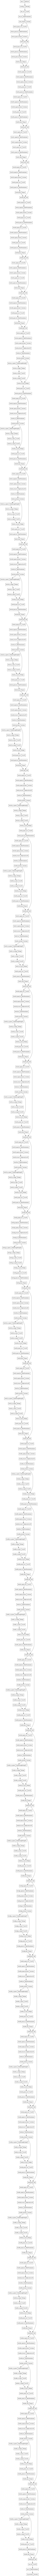

In [ ]:
feat = EfficientNetV2S(include_top=False, weights="imagenet", input_shape=(256,256,3))
tensorflow.keras.utils.plot_model(feat, to_file='feat.png')